# Pseudo Label

## Setup

In [1]:
import os
import sys
import random

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K

from PIL import Image
from tensorflow.keras.optimizers import Adam

from project_utils import *
from SatelliteImageData import *

%reload_ext autoreload
%autoreload 2

sys.path.append('../lib/')

random.seed(0)
np.set_printoptions(suppress=True)
weights = [0.001, 0.0033, 0.0053, 0.0015, 0.0003, 0.0002, 0.0088, 0.0248, 0.8125, 0.1423]

K.set_image_data_format('channels_last')
tf.get_logger().setLevel('ERROR')
strategy = tf.distribute.MirroredStrategy()

## Create Dataset

In [2]:
data_root_dir = '../../datasets/dstl-satellite-imagery-feature-detection/'
img_data = SatelliteImageData(data_root_dir)

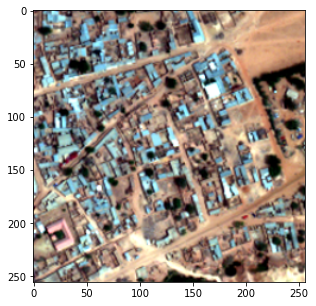

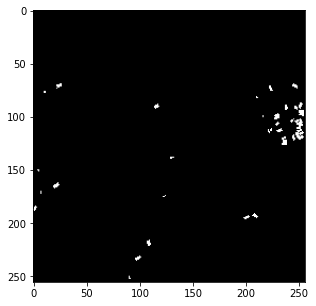

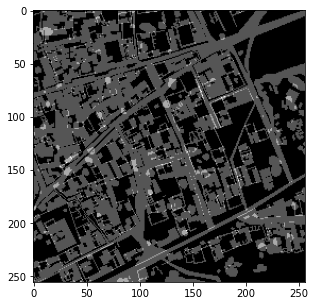

In [3]:
import cv2

temp_img_id = '6120_2_2'
img_size = (1024, 1024)
patch_shape=(256, 256)
patch_coord=(1, 3)

temp_img = img_data.get_visual_m_band_img(temp_img_id)
temp_img = cv2.resize(temp_img, img_size, interpolation=cv2.INTER_LINEAR)
temp_stacked_masks = img_data.get_stacked_masks(img_size, temp_img_id)

temp_img_patch = get_patch(temp_img, patch_shape, patch_coord)
temp_masks_patch = get_patch(temp_stacked_masks, patch_shape, patch_coord)

display_rgb_img(temp_img_patch)
display_mask(temp_masks_patch[:,:,9])
display_stacked_masks(temp_masks_patch)

temp_p_img = img_data.get_m_band_img(temp_img_id)
temp_p_img = img_data.stretch_n_bit(temp_p_img)
temp_p_img = cv2.resize(temp_p_img, img_size, interpolation=cv2.INTER_LINEAR)
temp_p_img_patch = get_patch(temp_p_img, patch_shape, patch_coord)
temp_p_img_patch = temp_p_img_patch[np.newaxis, ...]

## Generate Pseudo Label

In [4]:
from image_segmentation_keras.keras_segmentation.models.fcn import fcn_8_vgg

with strategy.scope():
    pseudo_label_model = fcn_8_vgg(
        input_height=256,
        input_width=256,
        input_channels=8,
        n_classes=10
    )

    pseudo_label_model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss=weighted_categorical_crossentropy(weights),
        metrics=['accuracy', 'categorical_accuracy', calc_mean_iou]
    )

pseudo_label_model.load_weights('saved_weights/baseline_weights/fcn_base.h5')

unlabelled_patch_ids = list(np.load(img_data.processed_data_dir + 'unlabelled_patch_ids.npy'))

for i, img_id in enumerate(unlabelled_patch_ids):
    if os.path.isfile(img_data.processed_data_dir + 'msks/{}.npy'.format(img_id)):
        continue
    
    if (i/len(unlabelled_patch_ids)*100)%10 == 0:
        print(i, '/', len(unlabelled_patch_ids))
    
    temp_img_patch = np.load(img_data.processed_data_dir + 'imgs/{}.npy'.format(img_id))
    temp_img_patch = temp_img_patch[np.newaxis, ...]
    
    y_pred = pseudo_label_model.predict(temp_img_patch)
    y_pred_mask = y_pred[0]
    y_pred_mask[y_pred_mask > 0.3] = 1
    y_pred_mask[y_pred_mask <= 0.3] = 0
    
    np.save(img_data.processed_data_dir + 'msks/{}.npy'.format(img_id), y_pred_mask)

In [5]:
labelled_patch_ids = list(np.load(img_data.processed_data_dir + 'labelled_patch_ids.npy'))
print(len(labelled_patch_ids))
print(len(unlabelled_patch_ids))

400
6800


## Greate Data Generator with Pseudo Labels

In [6]:
random.shuffle(labelled_patch_ids)
splitted_id_list = split_list(labelled_patch_ids, split_ratio=(0.8, 0.1, 0.1))
splitted_id_list[0] = splitted_id_list[0] + unlabelled_patch_ids

data_generators = []
for id_list in splitted_id_list:
    data_generators.append(SlicedSatelliteDataGenerator(img_data.processed_data_dir,
                                                        id_list,
                                                        input_shape=(256,256,8),
                                                        num_classes=10,
                                                        batch_size=10))

## Models

### UNet

In [7]:
from keras_unet.models import satellite_unet

with strategy.scope():
    unet_model = satellite_unet(
        input_shape=(256, 256, 8),
        num_classes=10,
    )

    unet_model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss=weighted_categorical_crossentropy(weights),
        # metrics=[calc_mean_iou],
        metrics=['accuracy', 'categorical_accuracy', calc_mean_iou]
    )

# unet_history = unet_model.fit(
#     data_generators[0],
#     epochs=200,
#     validation_data=data_generators[1]
# )

# plt.plot(unet_history.history['loss'])

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [8]:
# unet_model.save_weights('saved_weights/unet_pl.h5')

4/4 [==============================] - 0s 90ms/step - loss: 0.0012 - accuracy: 0.3021 - categorical_accuracy: 0.3021 - calc_mean_iou: 0.1361
tf.Tensor(
[0.13333745 0.01427057 0.20801313 0.03362339 0.26475018 0.408742
 0.23046035 0.06672923 0.00000246 0.00136138], shape=(10,), dtype=float32)
0.13612902


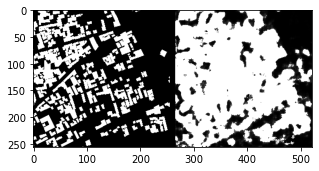

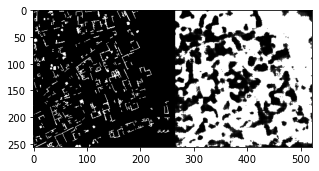

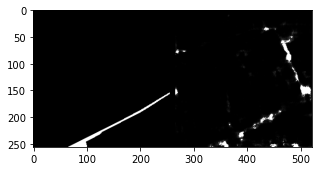

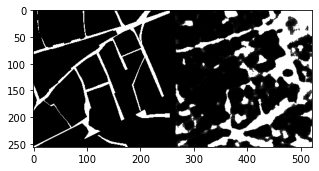

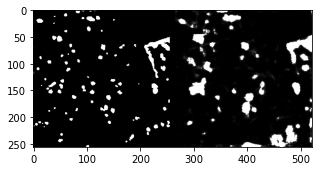

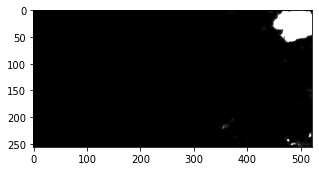

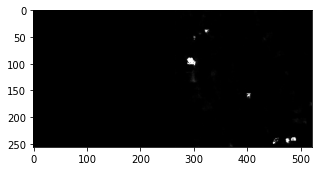

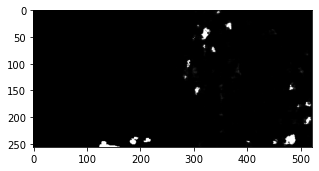

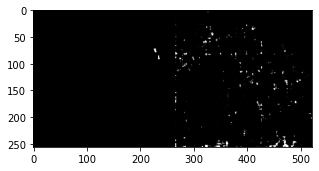

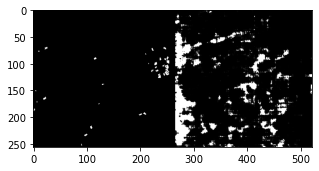

In [9]:
unet_model.load_weights('saved_weights/pseudo_label_weights/unet_pl.h5')

unet_model.evaluate(data_generators[2])
iou = evaluate_iou(data_generators[2], unet_model)
print(iou)
print(np.mean(iou))

unet_prediction = unet_model.predict(temp_p_img_patch)
unet_tmp_p_masks = unet_prediction[0]
unet_tmp_p_masks[unet_tmp_p_masks > 0.3] = 1

for i in range(10):
    maerged_mask = np.concatenate([temp_masks_patch[:,:,i], np.zeros((256,10)), unet_tmp_p_masks[:,:,i]], axis=1)
    display_mask(maerged_mask)

### FCN

In [10]:
from image_segmentation_keras.keras_segmentation.models.fcn import fcn_8_vgg

with strategy.scope():
    fcn_model = fcn_8_vgg(
        input_height=256,
        input_width=256,
        input_channels=8,
        n_classes=10
    )

    fcn_model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss=weighted_categorical_crossentropy(weights),
        metrics=['accuracy', calc_mean_iou]
    )

# fcn_history = fcn_model.fit(
#     data_generators[0],
#     epochs=200,
#     validation_data=data_generators[1]
# )

# plt.plot(fcn_history.history['loss'])

In [11]:
# fcn_model.save_weights('saved_weights/fcn_pl.h5')

4/4 [==============================] - 0s 122ms/step - loss: 4.7338e-04 - accuracy: 0.4309 - calc_mean_iou: 0.2464
tf.Tensor(
[0.4103458  0.04485116 0.39268684 0.05352447 0.26717064 0.66302943
 0.39827836 0.22582154 0.00347685 0.00462864], shape=(10,), dtype=float32)
0.24638137


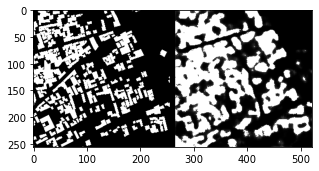

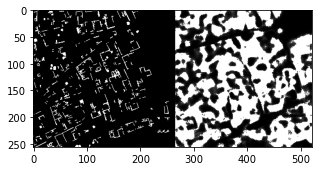

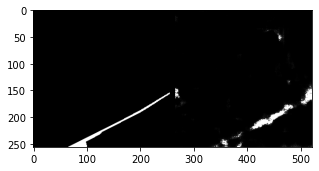

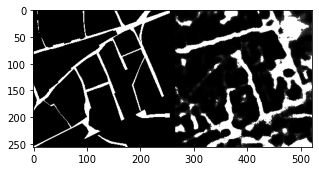

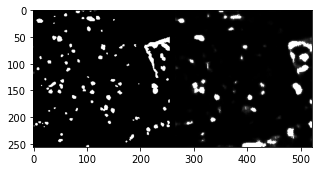

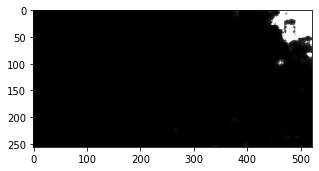

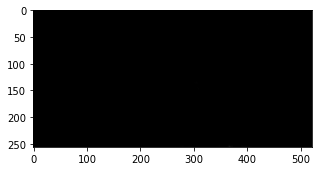

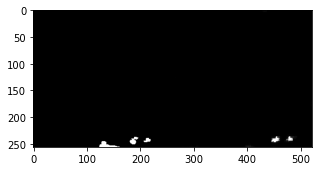

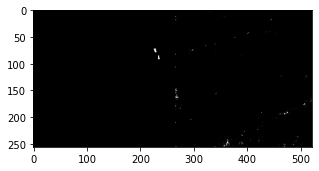

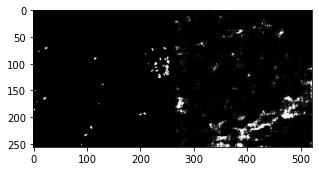

In [12]:
fcn_model.load_weights('saved_weights/pseudo_label_weights/fcn_pl.h5')

fcn_model.evaluate(data_generators[2])
iou = evaluate_iou(data_generators[2], fcn_model)
print(iou)
print(np.mean(iou))

fcn_prediction = fcn_model.predict(temp_p_img_patch)
fcn_tmp_p_masks = fcn_prediction[0]
fcn_tmp_p_masks[fcn_tmp_p_masks > 0.3] = 1

for i in range(10):
    maerged_mask = np.concatenate([temp_masks_patch[:,:,i], np.zeros((256,10)), fcn_tmp_p_masks[:,:,i]], axis=1)
    display_mask(maerged_mask)

### SegNet

In [13]:
from keras_segnet.segnet import SegNet

with strategy.scope():
    segnet_model = SegNet(
        input_shape=(256, 256, 8),
        classes=10
    )

    segnet_model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss=weighted_categorical_crossentropy(weights),
        metrics=['accuracy', calc_mean_iou]
    )

# segnet_history = segnet_model.fit(
#     data_generators[0],
#     epochs=200,
#     validation_data=data_generators[1]
# )

# plt.plot(segnet_history.history['loss'])

In [14]:
# segnet_model.save_weights('saved_weights/segnet_pl.h5')

4/4 [==============================] - 0s 77ms/step - loss: 6.6040e-04 - accuracy: 0.3942 - calc_mean_iou: 0.2091
tf.Tensor(
[0.28424892 0.03380314 0.39444417 0.04714006 0.26058036 0.49347812
 0.47651228 0.09983213 0.00002492 0.00101237], shape=(10,), dtype=float32)
0.20910767


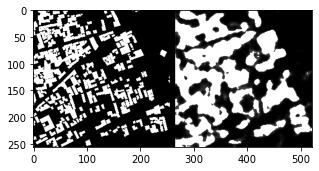

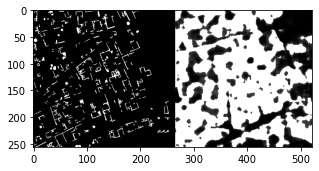

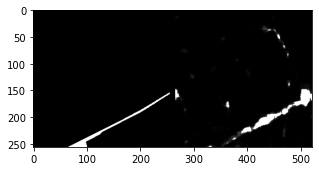

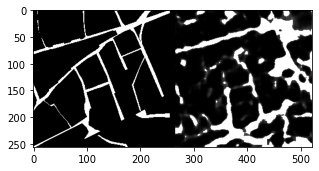

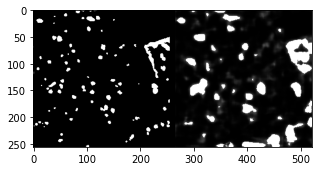

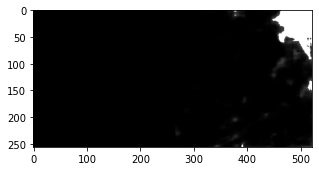

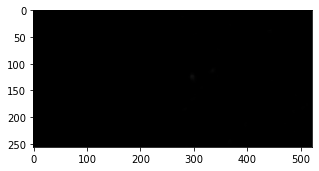

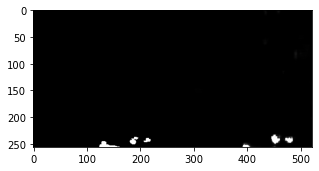

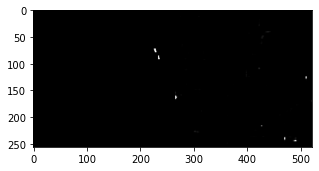

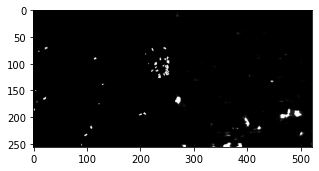

In [15]:
segnet_model.load_weights('saved_weights/pseudo_label_weights/segnet_pl.h5')

segnet_model.evaluate(data_generators[2])
iou = evaluate_iou(data_generators[2], segnet_model)
print(iou)
print(np.mean(iou))

segnet_prediction = segnet_model.predict(temp_p_img_patch)
segnet_tmp_p_masks = segnet_prediction[0]
segnet_tmp_p_masks[segnet_tmp_p_masks > 0.3] = 1

for i in range(10):
    maerged_mask = np.concatenate([temp_masks_patch[:,:,i], np.zeros((256,10)), segnet_tmp_p_masks[:,:,i]], axis=1)
    display_mask(maerged_mask)

### DeepLab V3 Plus

In [16]:
from keras_deeplab_v3_plus.model import Deeplabv3

with strategy.scope():
    deeplab_model = Deeplabv3(
        weights=None,
        input_shape=(256, 256, 8),
        classes=10,
        activation='softmax',
        backbone='xception',
        OS=16
    )

    deeplab_model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss=weighted_categorical_crossentropy(weights),
        metrics=['accuracy', calc_mean_iou]
    )

# deeplab_history = deeplab_model.fit(
#     data_generators[0],
#     epochs=200,
#     validation_data=data_generators[1]
# )

# plt.plot(deeplab_history.history['loss'])

In [17]:
# deeplab_model.save_weights('saved_weights/deeplab_pl.h5')

4/4 [==============================] - 0s 119ms/step - loss: 7.6539e-04 - accuracy: 0.3999 - calc_mean_iou: 0.2228
tf.Tensor(
[0.3032174  0.04018611 0.36499673 0.05146693 0.25163183 0.5176333
 0.45664084 0.24214622 0.00000569 0.00036267], shape=(10,), dtype=float32)
0.22282879


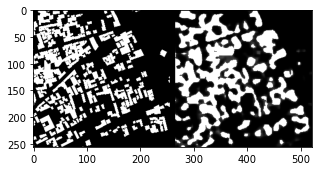

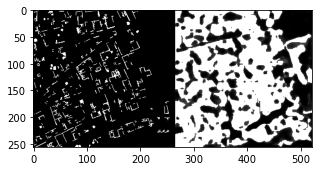

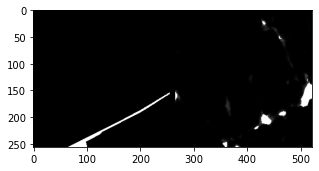

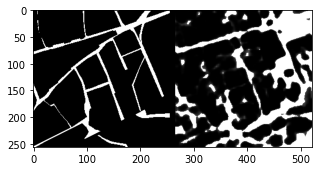

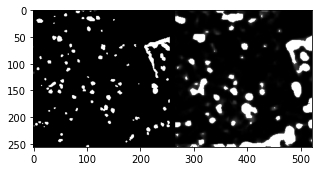

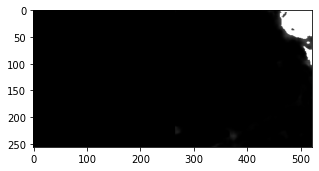

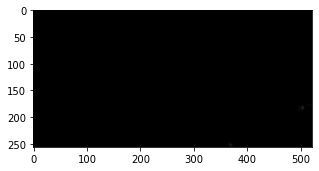

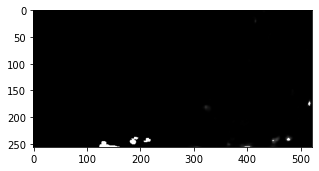

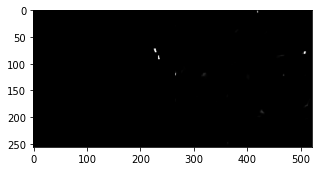

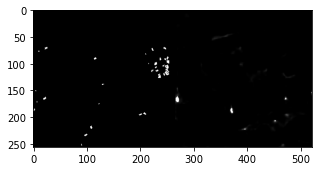

In [18]:
deeplab_model.load_weights('saved_weights/pseudo_label_weights/deeplab_pl.h5')

deeplab_model.evaluate(data_generators[2])
iou = evaluate_iou(data_generators[2], deeplab_model)
print(iou)
print(np.mean(iou))

deeplab_prediction = deeplab_model.predict(temp_p_img_patch)
deeplab_tmp_p_masks = deeplab_prediction[0]
deeplab_tmp_p_masks[deeplab_tmp_p_masks > 0.3] = 1

for i in range(10):
    maerged_mask = np.concatenate([temp_masks_patch[:,:,i], np.zeros((256,10)), deeplab_tmp_p_masks[:,:,i]], axis=1)
    display_mask(maerged_mask)